# Libraries

In [29]:
import os
import librosa   #for audio processing
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

# Data exploration and visualization

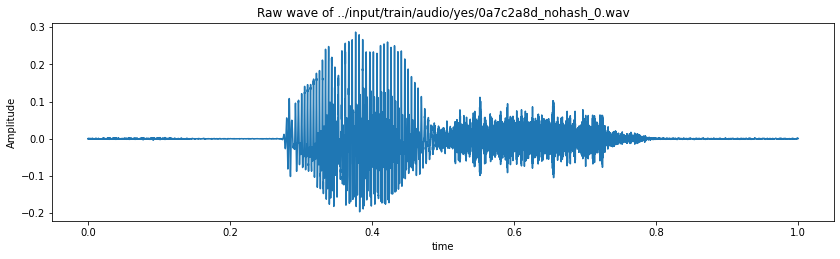

In [30]:
train_audio_path = 'C:/Users/Soukaina/OneDrive/Bureau/M1 S2/PFA/tensorflow-speech-recognition-challenge/train/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

#### Sampling and other inforamtions 

In [31]:
print("Data:",samples)
print("Length data:",len(samples))
print("Sampling rate:",sample_rate)

Data: [ 0.00042725 -0.00021362 -0.00042725 ...  0.00057983  0.00061035
  0.00082397]
Length data: 16000
Sampling rate: 16000


#### Resampling

From the above, we can understand that the sampling rate of the signal is 16,000 Hz. Let us re-sample it to 8000 Hz since most of the speech-related frequencies are present at 8000 Hz

In [32]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

##### Visualization using LIBROSA :

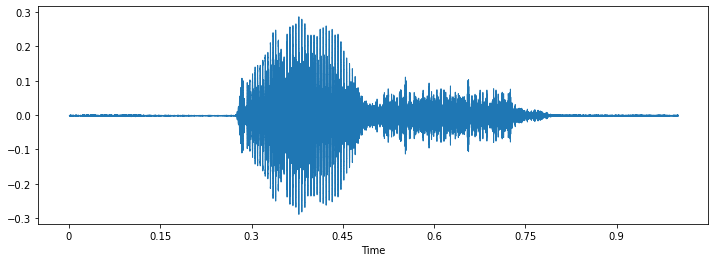

In [40]:
samples, sample_rate=librosa.load('C:/Users/Soukaina/OneDrive/Bureau/M1 S2/PFA/tensorflow-speech-recognition-challenge/train/train/audio/yes/0a7c2a8d_nohash_0.wav',sr=None)
plt.figure(figsize=(12,4))
librosa.display.waveshow(samples,sr=sample_rate)

In [41]:
import matplotlib.style as ms

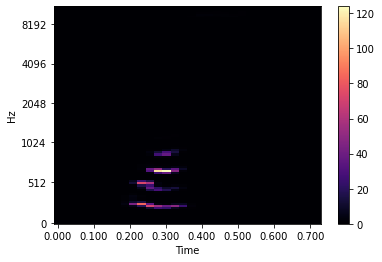

In [42]:
melspec=librosa.feature.melspectrogram(y=samples,sr=sample_rate)
plt.figure()
librosa.display.specshow(melspec,y_axis='mel',x_axis='time')
plt.colorbar()

In [43]:
import librosa.feature

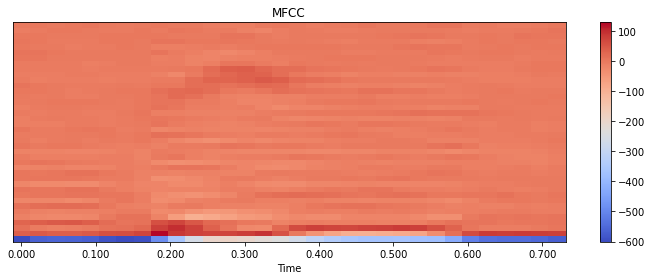

In [46]:
mfccs=librosa.feature.mfcc(y=samples,sr=sample_rate,n_mfcc=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs,x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

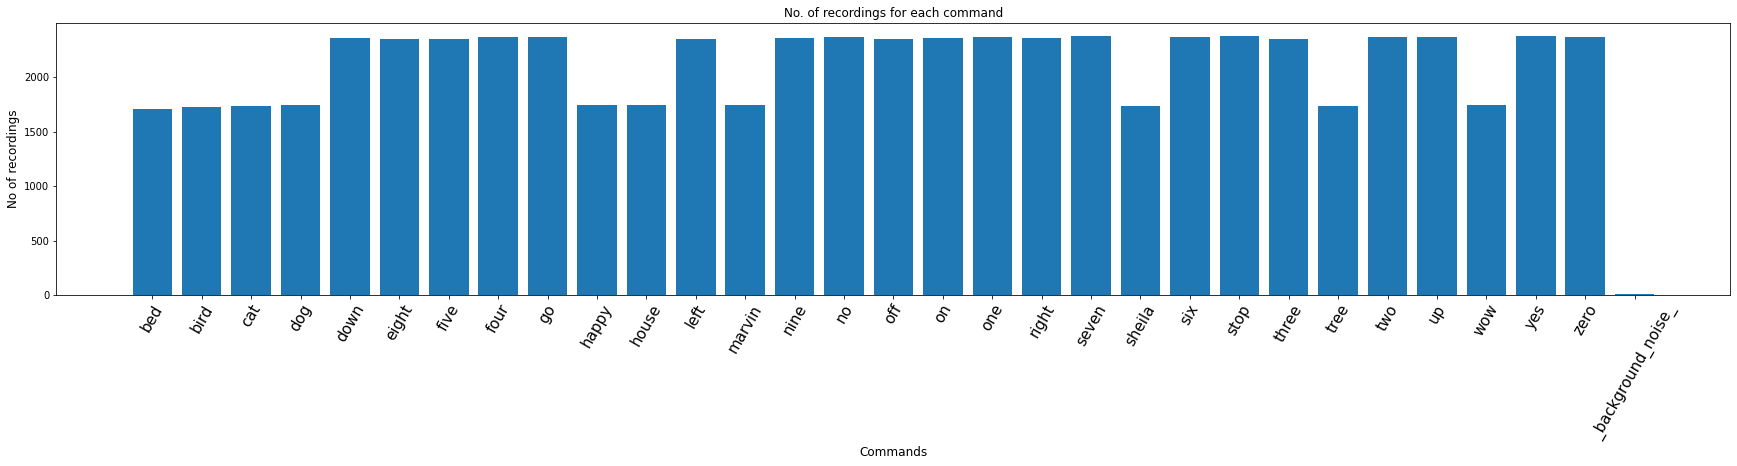

In [33]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#### Duration of recording 

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

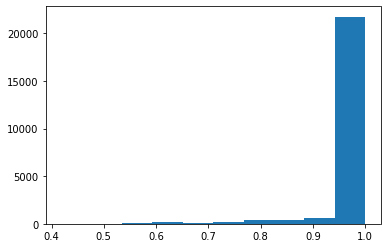

In [47]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

#### Preprocessing audio waves 

1-Resampling

2-Removing shorter commands of less than 1 second

In [48]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


#### Prepare a multi-classification audio wave into one hot vector

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [50]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [51]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

#### Data Splitting into train and Test dataset

In [52]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

## Training our model

In [53]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [54]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [57]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 84s 158ms/step - loss: 1.2774 - accuracy: 0.5351 - val_loss: 1.0871 - val_accuracy: 0.6331
Epoch 2/100
533/533 [==============================] - 82s 154ms/step - loss: 1.1015 - accuracy: 0.6065 - val_loss: 0.9120 - val_accuracy: 0.7021
Epoch 3/100
533/533 [==============================] - 83s 155ms/step - loss: 0.9590 - accuracy: 0.6584 - val_loss: 0.8623 - val_accuracy: 0.7049
Epoch 4/100
533/533 [==============================] - 81s 152ms/step - loss: 0.8617 - accuracy: 0.6995 - val_loss: 0.7473 - val_accuracy: 0.7516
Epoch 5/100
533/533 [==============================] - 82s 154ms/step - loss: 0.7704 - accuracy: 0.7337 - val_loss: 0.7843 - val_accuracy: 0.7347
Epoch 6/100
533/533 [==============================] - 81s 152ms/step - loss: 0.7210 - accuracy: 0.7520 - val_loss: 0.6460 - val_accuracy: 0.7816
Epoch 7/100
533/533 [==============================] - 81s 153ms/step - loss: 0.6560 - accuracy: 0.7727 - val_loss: 0.6256 -

533/533 [==============================] - 81s 152ms/step - loss: 0.3381 - accuracy: 0.8841 - val_loss: 0.4866 - val_accuracy: 0.8461
Epoch 28/100
533/533 [==============================] - 80s 150ms/step - loss: 0.3301 - accuracy: 0.8883 - val_loss: 0.4657 - val_accuracy: 0.8492
Epoch 29/100
533/533 [==============================] - 80s 150ms/step - loss: 0.3107 - accuracy: 0.8925 - val_loss: 0.4897 - val_accuracy: 0.8464
Epoch 30/100
533/533 [==============================] - 82s 153ms/step - loss: 0.3262 - accuracy: 0.8854 - val_loss: 0.4862 - val_accuracy: 0.8428
Epoch 31/100
533/533 [==============================] - 85s 159ms/step - loss: 0.3111 - accuracy: 0.8914 - val_loss: 0.5018 - val_accuracy: 0.8438
Epoch 32/100
533/533 [==============================] - 81s 152ms/step - loss: 0.2940 - accuracy: 0.8961 - val_loss: 0.5325 - val_accuracy: 0.8313
Epoch 33/100
533/533 [==============================] - 81s 151ms/step - loss: 0.3015 - accuracy: 0.8964 - val_loss: 0.4976 - val_a

#### Model validation

We validate our model using test dataset using plot

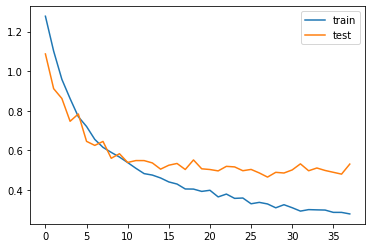

In [58]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

#### Loading the best model

In [59]:
from keras.models import load_model
model.save("model.h5")


In [60]:
model = load_model('model.h5')

In [61]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [62]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: up
1/1 [==============================] - 0s 248ms/step
Text: up


In [63]:
os.listdir('C:/Users/Soukaina/OneDrive/Bureau/M1 S2/PFA/tensorflow-speech-recognition-challenge/train/train/audio')
filepath='C:/Users/Soukaina/OneDrive/Bureau/M1 S2/PFA/tensorflow-speech-recognition-challenge/train/train/audio/stop/0ab3b47d_nohash_0.wav'

#reading the voice commands
samples, sample_rate = librosa.load(filepath, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

1/1 [==============================] - 0s 35ms/step


'stop'

#### Record your voice to test the model

In [68]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'down.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [69]:
os.listdir('C:/Users/Soukaina/')
filepath='C:/Users/Soukaina/down.wav'
samples, sample_rate = librosa.load(filepath, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
predict(samples)

1/1 [==============================] - 0s 21ms/step


'down'

In [70]:
os.listdir('C:/Users/Soukaina/')
filepath='C:/Users/Soukaina/right.wav'
samples, sample_rate = librosa.load(filepath, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
predict(samples)

1/1 [==============================] - 0s 20ms/step


'right'

In [71]:
os.listdir('C:/Users/Soukaina/')
filepath='C:/Users/Soukaina/up.wav'
samples, sample_rate = librosa.load(filepath, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
predict(samples)

1/1 [==============================] - 0s 29ms/step


'up'

In [72]:
os.listdir('C:/Users/Soukaina/')
filepath='C:/Users/Soukaina/left.wav'
samples, sample_rate = librosa.load(filepath, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
predict(samples)

1/1 [==============================] - 0s 31ms/step


'no'

In [73]:
def record():
    samplerate = 16000  
    duration = 1 # seconds
    filename = 'down.wav'
    print("start")
    mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
    print("end")
    sd.wait()
    sf.write(filename, mydata, samplerate)